

# <font size="+3"><span style='color:#2994ff'> **P7 - Implémentez un modèle de scoring** </span></font>


<a id='LOADING_LIBRARIES'></a>

---

---

<font size="+1"> **LOADING THE LIBRARIES** </font>

---

In [1]:

# ----------------
# Packages Update
# ----------------
# !pip install --upgrade pip
# !pip install xgboost
# !pip install pycodestyle
# !pip install flake8 pycodestyle_magic

# General libraries
import sys
import os
import glob
import pandas as pd
import numpy as np
import csv
import time
from datetime import datetime
import pickle

from xgboost import XGBRegressor

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor

import tools_dataframe
import tools_preprocessing
import tools_feat_engineering



# Data visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns



# Validation code PEP8
# %load_ext pycodestyle_magic
# %pycodestyle_on

# Warnings
# import warnings
# from warnings import simplefilter
# warnings.filterwarnings(action='once')
# simplefilter(action='ignore', category=FutureWarning)
# simplefilter(action='ignore', category=ValueError)
# simplefilter(action='ignore', category=UserWarning)

# Versions
print('Version of used libraries :')

print('Python                : ' + sys.version)
print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Dataframe tools      : ' + tools_dataframe.__version__)
now = datetime.now().isoformat()
print('Launched on : ' + now)

2023-07-04 17:30:22.561994: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-04 17:30:22.597891: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-04 17:30:22.598280: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-04 17:30:23.284615: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Version of used libraries :
Python                : 3.9.13 (main, Aug 25 2022, 23:26:10) 
[GCC 11.2.0]
NumPy                 : 1.23.5
Pandas                : 1.5.3
Dataframe tools      : 0.0.0
Launched on : 2023-07-04T17:30:23.893961



<a id='USED_PARAMETERS'></a>


<br>


---
---

<font size="+1"> **PARAMETERS USED IN THIS NOTEBOOK** </font>

---


In [2]:
# Parameters used in this notebook

seed = 84

palette4 = ["#253d85", "#618576", "#cba87d", "#faec4d"]

palette5 = ["#253d85", "#618576", "#9595b1", "#cba87d", "#faec4d"]

palette6 = ["#253d85", "#618576", "#9595b1", "#cba87d", "#dcd2a3", "#faec4d"]

In [3]:
dico_pd_option = {
    'display.max_rows': 400,
    'display.max_column': 200,
    'display.width': 300,
    'display.precision': 4,
    'display.max_colwidth': 1000,
    'mode.chained_assignment': None
}
for key, value in dico_pd_option.items():
    pd.set_option(key, value)

In [4]:
# Define the folder containing the files with the project data
P7_source = "/home/raquelsp/Documents/Openclassrooms/P7_implementez_modele_scoring/P7_travail/p7_source"

os.chdir(P7_source)


<a id='USED_FUNCTIONS'></a>


<br>


---
---

<font size="+1"> **FUNCTIONS USED IN THIS NOTEBOOK** </font>

---



<font size="+3"><span style='color:#2994ff'> **P7 - Implémentez un modèle de scoring** </span></font>


<center><img src="./img/logo_projet.png" style="height: 250px;"/></center>

**Prêt à dépenser** wants to implement a **credit scoring tool to calculate the probability of a customer repaying their loan**, and then **classify the application as either granted or refused credit**. It therefore wants to develop a classification algorithm based on a variety of data sources (behavioural data, data from other financial institutions, etc.).

This notebook includes the **pre-processing** of data sets and the **feature engineering**:


- application_train/set.csv,

- office.csv**,

- office_balance.csv**,

- credit_card_balance.csv**,

- installments_payments.csv**,

- POS_CASH_balance.csv**,

- previous_application.csv


In particular:


- Cleaning** :

    - memory optimisation** by changing the data type. 

    - correction of **outliers**
    
    - correction of duplicated data

    - imputation** of missing values

- Feature engineering**: in this section, we will start by using the knowledge and insights gained from exploratory data analysis to obtain good sets of variables using feature engineering. Note that most of the variables generated are based on domain knowledge and experimentation. Without good sets of variables, machine learning algorithms cannot produce effective results. We will therefore have to find ingenious ways of doing feature engineering so that the model makes better decisions. 

- Aggregation**: with main data from Home Crédit Group.


***

Sources

***

The aggregation functions have been taken from the notebook: [Source](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering/output) by adapting the signature to pass the prefix of the column names and to be able to pass a dictionary of the statistics you want to add.


## <font color = '#0085dd'>**Table of content**</font>


[Librairies loading](#LOADING_LIBRARIES)<br>

[Functions used in this notebook](#USED_FUNCTIONS)<br>

---

[**Datasets**](#datasets)
 * [Description](#datasets_description)
   * [orders_dataset](#orders_dataset)
   * [customers_dataset](#customers_dataset)
   * [order_items](#order_items)
   * [products_dataset](#products_dataset)
   * [product_category_name_translation](#product_category_name_translation)   
   * [sellers_dataset](#sellers_dataset)
   * [order_payments](#order_payments)
   * [order_reviews](#order_reviews)
   * [geolocation_dataset](#geolocation_dataset)<br> 
<br>
 * [Columns preparation](#columns_preparation)
   * [Zip codes centroids calculation](#centroid_zipCode)
   * [Product category check and update](#cat_products)   
   
   
[**Datasets joining**](#datasets_joining)
 * [Data description](#data_description)
 * [Evaluation of missing values](#missing_values)  
 * [Column filling analysis](#column_fill)   
 * [Row filling analysis](#row_filling)  
 * [Features pre-selection](#features_preSelection)

[**Features engineering**](#features_engineering)
 * [Customers spatial distribution](#customers_spatial_distribution)
 * [RFM features](#RFM_features)  
 * [Products](#products)   
 * [Orders](#Orders)  
 * [Dates](#dates)
 * [Joining customers information](#join_customers_datasets)
 * [Features analysis](#features_analysis)  

[**Dataset for segmentation**](#segmentation_dataset)
<br>

---


<a id='datasets_loading'></a>

---
---

# <span style='background:#2994ff'><span style='color:white'>**Train and test datasets** </span></span>


| File | Description |
| --- | --- |
| <p style='text-align: justify;'>**application_train.csv** <br> **application_test.csv**</p> | <ul style='text-align: justify;'><li>The main table, divided into two files for Train (with TARGET) and Test (without TARGET).</li> <li>Static data for all applications.</li><li>A line represents a loan in our data sample.</li></ul> |

In [5]:
# -----------------------------
# Files upload:
# -----------------------------

# Train and Test datasets
application_train = pd.read_csv('application_train.csv', low_memory=False,
                            encoding='utf-8')
application_test = pd.read_csv('application_test.csv', low_memory=False,
                           encoding='utf-8')

In [6]:
# --------------
# Dataset size
# --------------
nRow, nVar = application_train.shape
print(f'The application_train dataset contains {nRow} rows and {nVar} variables.')
print()
nRow, nVar = application_test.shape
print(f'The application_test dataset contains {nRow} rows and {nVar} variables.')

The application_train dataset contains 307511 rows and 122 variables.

The application_test dataset contains 48744 rows and 121 variables.


train_dataset


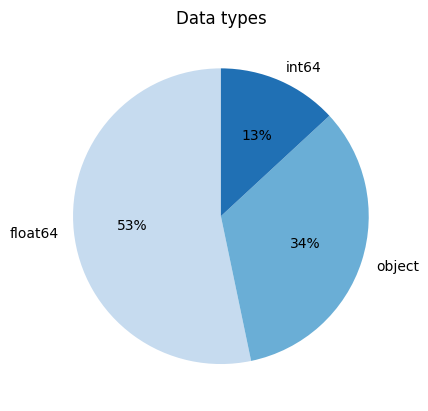

In [7]:
# --------------------
# Variable types
# --------------------
info_train = tools_dataframe.complet_description(application_train)
print("train_dataset")
tools_dataframe.visu_dataTypes(info_train)

test_dataset


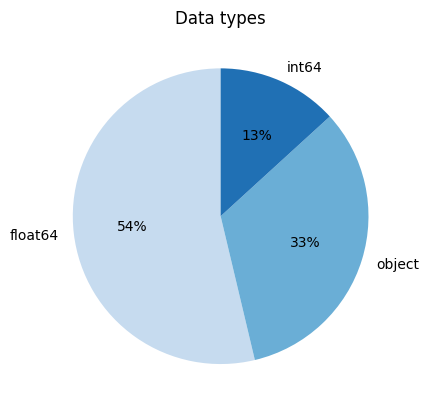

In [8]:
# --------------------
# Variable types
# --------------------
info_test = tools_dataframe.complet_description(application_test)
print("test_dataset")
tools_dataframe.visu_dataTypes(info_test)

In [9]:
# Continous variables
cols_num_train = application_train.select_dtypes(include=[np.number])\
                                    .columns.to_list()
cols_num_test = application_test.select_dtypes(include=[np.number])\
                                    .columns.to_list()

In [10]:
# Categorical variables
cols_cat_train = application_train.select_dtypes(exclude=[np.number])\
                                    .columns.to_list()
cols_cat_test = application_test.select_dtypes(exclude=[np.number])\
                                    .columns.to_list()

In [11]:
# ----------------------------------------------------
# Memory improvement by reducing the size of objects
# ----------------------------------------------------
print("application_train")
application_train =\
    tools_preprocessing.reduce_mem_usage(application_train, verbose=True)

application_train
-------------------------------------------------------------------------------
Memory usage of dataframe is: 286.23 MB
Memory usage after optimization is : 92.38 MB
Reduction of 67.7%
-------------------------------------------------------------------------------


In [12]:
# ----------------------------------------------------
# Memory improvement by reducing the size of objects
# ----------------------------------------------------
print("application_test")
application_test =\
    tools_preprocessing.reduce_mem_usage(application_test, verbose=True)

application_test
-------------------------------------------------------------------------------
Memory usage of dataframe is: 45.00 MB
Memory usage after optimization is : 14.60 MB
Reduction of 67.6%
-------------------------------------------------------------------------------


In [13]:
# Manual changes : REGION_RATING_CLIENT contains 1, 2 and 3
# ==> object
application_train['REGION_RATING_CLIENT'] = \
    application_train['REGION_RATING_CLIENT'].astype('object')
# Manual changes : : REGION_RATING_CLIENT_W_CITY contains
# ==> 1, 2 ou 3 object
application_train['REGION_RATING_CLIENT_W_CITY'] = \
    application_train['REGION_RATING_CLIENT_W_CITY'].astype('object')

In [14]:
# # Manual changes : REGION_RATING_CLIENT contains 1, 2 and 3
# ==> object
application_test['REGION_RATING_CLIENT'] = \
    application_test['REGION_RATING_CLIENT'].astype('object')
# Manual changes : : REGION_RATING_CLIENT_W_CITY contains
# ==> 1, 2 ou 3 object
application_test['REGION_RATING_CLIENT_W_CITY'] = \
    application_test['REGION_RATING_CLIENT_W_CITY'].astype('object')

In [15]:
# EMERGENCYSTATE_MODE contains Yes/No ==> transform to 1/0
# %pycodestyle_off
dico_emergency = {'Yes' : 0,
                  'No' : 1,
                  np.nan : 0}
tools_preprocessing.transl_values(application_train,
                                  'EMERGENCYSTATE_MODE', dico_emergency)
application_train['EMERGENCYSTATE_MODE'] = \
    application_train['EMERGENCYSTATE_MODE'].astype('int8')
# %pycodestyle_on

In [16]:
# EMERGENCYSTATE_MODE contains Y/N ==> transformer en 1/0
# %pycodestyle_off
dico_emergency = {'Yes' : 0,
                  'No' : 1,
                  np.nan : 0}
tools_preprocessing.transl_values(application_test,
                                      'EMERGENCYSTATE_MODE', dico_emergency)
application_test['EMERGENCYSTATE_MODE'] = \
    application_test['EMERGENCYSTATE_MODE'].astype('int8')
# %pycodestyle_on

In [17]:
# FLAG_OWN_CAR contains Y/N ==> transformer en 1/0
# %pycodestyle_off
dico_owncar = {'Y' : 0,
               'N' : 1,
               np.nan : 0}
tools_preprocessing.transl_values(application_train, 'FLAG_OWN_CAR',
                                  dico_owncar)
application_train['FLAG_OWN_CAR'] = \
    application_train['FLAG_OWN_CAR'].astype('int8')
application_train['FLAG_OWN_CAR'].unique()
# %pycodestyle_on

array([1, 0], dtype=int8)

In [18]:
# FLAG_OWN_CAR contains Y/N ==> transformer en 1/0
# %pycodestyle_off
dico_owncar = {'Y' : 0,
               'N' : 1,
               np.nan : 0}
tools_preprocessing.transl_values(application_test, 'FLAG_OWN_CAR',
                                      dico_owncar)
application_test['FLAG_OWN_CAR'] = \
    application_test['FLAG_OWN_CAR'].astype('int8')
# %pycodestyle_on

In [19]:
# FLAG_OWN_REALTY contains Y/N ==> transformer en 1/0
# %pycodestyle_off
dico_ownreal = {'Y' : 0,
                'N' : 1,
                np.nan : 0}
tools_preprocessing.transl_values(application_train, 'FLAG_OWN_REALTY',
                                  dico_ownreal)
application_train['FLAG_OWN_REALTY'] = \
    application_train['FLAG_OWN_REALTY'].astype('int8')
application_train['FLAG_OWN_REALTY'].unique()
# %pycodestyle_on

array([0, 1], dtype=int8)

In [20]:
# FLAG_OWN_REALTY contains Y/N ==> transformer en 1/0
# %pycodestyle_off
dico_ownreal = {'Y' : 0,
                'N' : 1,
                np.nan : 0}
tools_preprocessing.transl_values(application_test, 'FLAG_OWN_REALTY',
                                      dico_ownreal)
application_test['FLAG_OWN_REALTY'] = \
    application_test['FLAG_OWN_REALTY'].astype('int8')
# %pycodestyle_on

In [21]:
# REMOVE UNINFORMATIVE VARIABLES

# there are some FLAG_DOCUMENT features having just one category
# for almost all data, we will remove those
flag_cols_to_drop = ['FLAG_DOCUMENT_2','FLAG_DOCUMENT_4',
                     'FLAG_DOCUMENT_10','FLAG_DOCUMENT_12',
                     'FLAG_DOCUMENT_20']
application_train = application_train.drop(flag_cols_to_drop, axis = 1)
application_test = application_test.drop(flag_cols_to_drop,  axis = 1)

In [22]:
# CORRECT TIME VARIABLES

#converting age from days to years
application_train['DAYS_BIRTH'] = application_train['DAYS_BIRTH'] * -1 / 365
application_test['DAYS_BIRTH'] = application_test['DAYS_BIRTH'] * -1 / 365
#From the EDA we saw some erroneous values in DAYS_EMPLOYED field
application_train['DAYS_EMPLOYED']\
    [application_train['DAYS_EMPLOYED'] == 365243] = np.nan
application_test['DAYS_EMPLOYED']\
    [application_test['DAYS_EMPLOYED'] == 365243] = np.nan

In [23]:
# REMOVE ERRONEUS VALUES IN OBS COLUMNS

application_train['OBS_30_CNT_SOCIAL_CIRCLE']\
    [application_train['OBS_30_CNT_SOCIAL_CIRCLE'] > 30] == np.nan
application_train['OBS_60_CNT_SOCIAL_CIRCLE']\
    [application_train['OBS_60_CNT_SOCIAL_CIRCLE'] > 30] == np.nan
application_test['OBS_30_CNT_SOCIAL_CIRCLE']\
    [application_test['OBS_30_CNT_SOCIAL_CIRCLE'] > 30] == np.nan
application_test['OBS_60_CNT_SOCIAL_CIRCLE']\
    [application_test['OBS_60_CNT_SOCIAL_CIRCLE'] > 30] == np.nan

37465    False
38869    False
39671    False
Name: OBS_60_CNT_SOCIAL_CIRCLE, dtype: bool

<a id='application_traintest_preprocessing'></a>

## <span style='background:#0085dd'><span style='color:white'>Application_train/test preprocessing</span></span>

<a id='application_traintest_outliers'></a>

### <span style='background:#0075bc'><span style='color:white'>Application_train/test outliers</span></span>

Correction of outliers detected during the EDA.

**DAYS_EMPLOYED**

From the 90th percentile, the value is 365243 days, i.e. 1000 years!

In [24]:
# Number of rows with errors
print("application_train")
nb_err = \
    application_train['DAYS_EMPLOYED'][application_train['DAYS_EMPLOYED']
                                       == 365243].count()
pourc_err = round((nb_err*100)/application_train.shape[0], 2)
print(f'Number of errors DAYS_EMPLOYED : {nb_err} ({pourc_err}%)')

application_train
Number of errors DAYS_EMPLOYED : 0 (0.0%)


In [25]:
# Correction
application_train['DAYS_EMPLOYED'][application_train['DAYS_EMPLOYED']
                                   == 365243] = np.nan

In [26]:
# Number of rows with errors
print("application_test")
nb_err = \
    application_test['DAYS_EMPLOYED'][application_test['DAYS_EMPLOYED']
                                       == 365243].count()
pourc_err = round((nb_err*100)/application_test.shape[0], 2)
print(f'Number of errors DAYS_EMPLOYED : {nb_err} ({pourc_err}%)')

application_test
Number of errors DAYS_EMPLOYED : 0 (0.0%)


In [27]:
# Correction
application_test['DAYS_EMPLOYED'][application_test['DAYS_EMPLOYED']
                                   == 365243] = np.nan

<a id='application__traintest_duplicated_data'></a>

### <span style='background:#0075bc'><span style='color:white'>Application_train/test duplicated data</span></span>

In [28]:
print("Duplicated data in application_train: ",\
      application_train.loc[application_train.duplicated()].shape[0])

Duplicated data in application_train:  0


In [29]:
print("Duplicated data in application_test: ",\
      application_test.loc[application_test.duplicated()].shape[0])

Duplicated data in application_test:  0


<a id='application_traintest_missing_values'></a>

### <span style='background:#0075bc'><span style='color:white'>Application_train/test missing values</span></span>

In [30]:
# Valeurs manquantes du dataframe
df_nan_applitrain = tools_dataframe.get_missing_values(application_train,
                                                       True, False, True)

Missing values : 9062084 NaN for 35978787 data (25.19 %)
-------------------------------------------------------------
Number and % of missing values by variable



,Number of missing values,% of missing values
COMMONAREA_MODE,214865,69.870000
COMMONAREA_AVG,214865,69.870000
COMMONAREA_MEDI,214865,69.870000
NONLIVINGAPARTMENTS_MEDI,213514,69.430000
NONLIVINGAPARTMENTS_AVG,213514,69.430000
NONLIVINGAPARTMENTS_MODE,213514,69.430000
FONDKAPREMONT_MODE,210295,68.390000
LIVINGAPARTMENTS_MODE,210199,68.350000
LIVINGAPARTMENTS_AVG,210199,68.350000
LIVINGAPARTMENTS_MEDI,210199,68.350000



* From the important variables identified during the exploratory analysis to distinguish non-defaulters from defaulters, the FLOORSMIN_AVG variable has the highest number of missing values (67.85%).
* We set the threshold for deleting variables with many missing values at 68%.

In [31]:
# List of variables with more than 68% of missing values
cols_nan_remov_train = \
    df_nan_applitrain[df_nan_applitrain['% of missing values'] > 68] \
    .index.to_list()
print(f'Number of variables to remove : {len(cols_nan_remov_train)}')
cols_nan_remov_train

Number of variables to remove : 10


['COMMONAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'COMMONAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'COMMONAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'FONDKAPREMONT_MODE']

In [32]:
# Remove with % of nan over the threshold > 68%
application_train.drop(columns=cols_nan_remov_train, inplace=True)

# Categorical variables
cols_cat_train = application_train.select_dtypes(exclude=[np.number])\
                                    .columns.to_list()
# Continuous variables
cols_num_train = application_train.select_dtypes(include=[np.number])\
                                    .columns.to_list()

# Size : number of rows/columns
nRow, nVar = application_train.shape
print(f'The dataset application_train contains {nRow} rows and {nVar} variables.')

The dataset application_train contains 307511 rows and 107 variables.


In [33]:
# Valeurs manquantes du dataframe
df_nan_applitest = tools_dataframe.get_missing_values(application_test,
                                                       True, False, True)

Missing values : 1391484 NaN for 5654304 data (24.61 %)
-------------------------------------------------------------
Number and % of missing values by variable



,Number of missing values,% of missing values
COMMONAREA_MEDI,33495,68.720000
COMMONAREA_MODE,33495,68.720000
COMMONAREA_AVG,33495,68.720000
NONLIVINGAPARTMENTS_MODE,33347,68.410000
NONLIVINGAPARTMENTS_AVG,33347,68.410000
NONLIVINGAPARTMENTS_MEDI,33347,68.410000
FONDKAPREMONT_MODE,32797,67.280000
LIVINGAPARTMENTS_MEDI,32780,67.250000
LIVINGAPARTMENTS_AVG,32780,67.250000
LIVINGAPARTMENTS_MODE,32780,67.250000



* From the important variables identified during the exploratory analysis to distinguish non-defaulters from defaulters, the FLOORSMIN_AVG variable has the highest number of missing values (66.61%).
* We set the threshold for deleting variables with many missing values at 67%.

In [34]:
# List of variables with more than 67% of missing values
cols_nan_remov_test = \
    df_nan_applitest[df_nan_applitest['% of missing values'] > 67] \
    .index.to_list()
print(f'Number of variables to remove : {len(cols_nan_remov_test)}')
cols_nan_remov_test

Number of variables to remove : 10


['COMMONAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'COMMONAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'COMMONAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'FONDKAPREMONT_MODE']

In [35]:
# Remove with % of nan over the threshold > 67%
application_test.drop(columns=cols_nan_remov_test, inplace=True)

# Categorical variables
cols_cat_test = application_test.select_dtypes(exclude=[np.number])\
                                    .columns.to_list()
# Continuous variables
cols_num_test = application_test.select_dtypes(include=[np.number])\
                                    .columns.to_list()

# Size : number of rows/columns
nRow, nVar = application_test.shape
print(f'The dataset application_test contains {nRow} rows and {nVar} variables.')

The dataset application_test contains 48744 rows and 106 variables.


<a id='application_train_assign_missing_values'></a>

---
#### <span style='background:#0075bc'><span style='color:white'>Application_train assignment missing values</span></span>

* During the exploratory analysis, it was observed that values that were not provided could give indications. The applicant may have withheld information to avoid having his application refused.
* The EDA also revealed the existence of many outliers.
* The **missing values** of the **continuous variables** will be therefore imputed by the **median** of each of these variables.
* The **missing values** of the **categorical variables** will be therefore imputed by the **mode** of each of these variables.

**Continuous variables**

In [36]:
# application_train
nb_nan_median = application_train[cols_num_train].isna().sum().sum()
print(f'Number of nan in application_train before median assignment : {nb_nan_median}')
application_train.fillna(application_train[cols_num_train].median(), inplace=True)
# Validation
nb_nan_median = application_train[cols_num_train].isna().sum().sum()
print(f'Number of nan in application_train after median assignment : {nb_nan_median}')

Number of nan in application_train before median assignment : 6527734
Number of nan in application_train after median assignment : 0


In [37]:
# application_test
nb_nan_median = application_test[cols_num_test].isna().sum().sum()
print(f'Number of nan in application_test before median assignment : {nb_nan_median}')
application_test.fillna(application_test[cols_num_test].median(), inplace=True)
# Validation
nb_nan_median = application_test[cols_num_test].isna().sum().sum()
print(f'Number of nan in application_test after median assignment : {nb_nan_median}')

Number of nan in application_test before median assignment : 995793
Number of nan in application_test after median assignment : 0


**Categorical variables**

In [38]:
# application_train
nb_nan_cat = application_train[cols_cat_train].isna().sum().sum()
print(f'Number of nan in application_train before mode assignment : {nb_nan_cat}')
for var in cols_cat_train:
    mode = application_train[var].mode()[0]
    application_train[var].fillna(mode, inplace=True)
nb_nan_cat = application_train[cols_cat_train].isna().sum().sum()
print(f'Number of nan in application_train after mode assignment  : {nb_nan_cat}')

Number of nan in application_train before mode assignment : 408321
Number of nan in application_train after mode assignment  : 0


In [39]:
# application_test
nb_nan_cat = application_test[cols_cat_test].isna().sum().sum()
print(f'Number of nan in application_test before mode assignment : {nb_nan_cat}')
for var in cols_cat_test:
    mode = application_test[var].mode()[0]
    application_test[var].fillna(mode, inplace=True)
nb_nan_cat = application_test[cols_cat_test].isna().sum().sum()
print(f'Number of nan in application_test after mode assignment  : {nb_nan_cat}')

Number of nan in application_test before mode assignment : 64028
Number of nan in application_test after mode assignment  : 0


In [40]:
# Validation
print(f'Number of nan in application_train : {application_train.isna().sum().sum()}')
# Saving application_train
path_sav_appltrain_wonan = \
    '/home/raquelsp/Documents/Openclassrooms/P7_implementez_modele_scoring/P7_travail/P7_scoring_credit/preprocessing/application_train_wo_nan.pkl'
with open(path_sav_appltrain_wonan, 'wb') as f:
    pickle.dump(application_train, f, pickle.HIGHEST_PROTOCOL)

Number of nan in application_train : 0


In [41]:
# Validation
print(f'Number of nan in application_test : {application_test.isna().sum().sum()}')
# Saving application_train
path_sav_appltest_wonan = \
    '/home/raquelsp/Documents/Openclassrooms/P7_implementez_modele_scoring/P7_travail/P7_scoring_credit/preprocessing/application_test_wo_nan.pkl'
with open(path_sav_appltest_wonan, 'wb') as f:
    pickle.dump(application_test, f, pickle.HIGHEST_PROTOCOL)

Number of nan in application_test : 0


<a id='application_traintest_feat_engi'></a>

## <span style='background:#0085dd'><span style='color:white'>Application_train/test feat engineering</span></span>

These tables consists of static data relating to the Borrowers. Each row represents one loan application.

<ol><li>First we do feature engineering on the numeric features, and generate features based on Domain Knoweldge, such as INCOME TO ANNUITY ratio, EXT_SOURCE means, etc.</li>
    <li>We also try to predict the interest rates by using the data from the previous applications features, and predicting using the data from application_train features. We also create a feature based on the Target values from application_train where we compute the mean of targets of 500 nearest neighbors of each row.</li>
    <li>Next we create some features based on the categorical interactions by grouping the data on several categorical combinations and imputing the aggregates for each group as features.</li>
    <li>We encode the categorical features by response coding, as we didn't want to increase dimensionality by many-folds using OHE. </li>

In [43]:
application_train, application_test = tools_feat_engineering.feat_eng_application_train_test(dump_to_pickle = True).main()

###################################################
#        Pre-processing application_train         #
#        Pre-processing application_test          #
###################################################

Loading the DataFrames into memory...
Loaded application_train and application_test
Time Taken to load = 0:00:00.113707

Predicting the missing values of EXT_SOURCE columns...
Done.
Time elapsed = 0:05:44.035164

Starting Feature Engineering...

Creating Domain Based Features on Numeric Data
Done.
Time Taken = 0:03:02.130789
Creating features based on Categorical Interactions on some Numeric Features
Done.
Time taken = 0:00:01.297841


/home/raquelsp/Documents/Openclassrooms/P7_implementez_modele_scoring/P7_travail/P7_scoring_credit/tools_feat_engineering.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column + '_0'] = data[column].map(dict_mapping[0])
/home/raquelsp/Documents/Openclassrooms/P7_implementez_modele_scoring/P7_travail/P7_scoring_credit/tools_feat_engineering.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column + '_1'] = data[column].map(dict_mapping[1])
/home/raquelsp/Documents/Openclassrooms/P7_implementez_modele_scoring/

Done preprocessing appplication_train and application_test.

Initial Size of application_train: (307511, 107)
Size of application_train after Pre-Processing and Feature Engineering: (307511, 353)

Total Time Taken = 0:08:48.706103

Pickling application_train and application_test after feature engineering to application_train_aft_feat_eng.pkl and application_test_aft_feat_eng, respectively.
Done.
----------------------------------------------------------------------------------------------------


**Freeing up the memory**

In [44]:
path_temp = '../P7_scoring_credit/preprocessing/temp/'

filelist = [ f for f in os.listdir(path_temp) if f.endswith(".pkl") ]
for f in filelist:
    os.remove(os.path.join(path_temp, f))

<a id='application_traintest_manag_strong_correl'></a>

## <span style='background:#0085dd'><span style='color:white'>Application_train/test Managing strong correlations</span></span>

In this section:
 * The correlation between the numerical variables, Pearson's coefficient, is calculated.
 * The maximum accepted correlation threshold is set at 0.8.
 * The variables whose correlation exceeds the maximum threshold are suppressed.

In [45]:
# Load de dataset after feature engineering
path_sav_application_train_afteng =  '../P7_scoring_credit/preprocessing/application_train_aft_feat_eng.pkl'

with open(path_sav_application_train_afteng, 'rb') as f:
    application_train_aft_feat_eng = pickle.load(f)

In [46]:
# Load de dataset after feature engineering
path_sav_application_test_afteng =  '../P7_scoring_credit/preprocessing/application_train_aft_feat_eng.pkl'

with open(path_sav_application_test_afteng, 'rb') as f:
    application_test_aft_feat_eng = pickle.load(f)

In [47]:
# ----------------------------------------------------
# Memory improvement by reducing the size of objects
# ----------------------------------------------------
print("application_train")
application_train =\
    tools_preprocessing.reduce_mem_usage(application_train, verbose=True)

print("\napplication_test")
application_test =\
    tools_preprocessing.reduce_mem_usage(application_test, verbose=True)

application_train
-------------------------------------------------------------------------------
Memory usage of dataframe is: 375.38 MB
Memory usage after optimization is : 227.87 MB
Reduction of 39.3%
-------------------------------------------------------------------------------

application_test
-------------------------------------------------------------------------------
Memory usage of dataframe is: 59.46 MB
Memory usage after optimization is : 35.14 MB
Reduction of 40.9%
-------------------------------------------------------------------------------


In [48]:
# CORRELATION MATRIX application_train
# ---------------------------------------------------------------------

threshold = 0.8

# Absolute value correlation matrix to avoid having to manage
# positive and negative correlations separately
corr = application_train.corr().abs()

# Only the part above the diagonal is retained so that
# the correlations are taken into account only once (axial symmetry).
corr_triangle = corr.where(np.triu(np.ones(corr.shape), k=1)
                           .astype(np.bool))

/tmp/ipykernel_8612/2032991550.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.bool))


In [49]:
# Variables with a Pearson coef > 0.8?
cols_corr_a_supp = [var for var in corr_triangle.columns
                    if any(corr_triangle[var] > threshold)]
print(f'There are {len(cols_corr_a_supp)} variables in application_train with strong correlation to be removed.\n')

There are 158 variables in application_train with strong correlation to be removed.



In [50]:
# Drop vairables with strong correlation
print(f'application_train : {application_train.shape}')
application_train.drop(columns=cols_corr_a_supp,  inplace=True)
print(f'application_train : {application_train.shape}')

application_train : (307511, 353)
application_train : (307511, 195)


In [51]:
# Drop vairables with strong correlation
print(f'application_test : {application_test.shape}')
application_test.drop(columns=cols_corr_a_supp,  inplace=True)
print(f'application_test : {application_test.shape}')

application_test : (48744, 352)
application_test : (48744, 194)


In [52]:
# Saving application_train ready for ML
path_sav_appltrain_ML = \
    '../P7_scoring_credit/preprocessing/application_train_ML.pkl'
with open(path_sav_appltrain_ML, 'wb') as f:
    pickle.dump(application_train, f, pickle.HIGHEST_PROTOCOL)

In [53]:
# Saving application_test ready for ML
path_sav_appltest_ML = \
    '../P7_scoring_credit/preprocessing/application_test_ML.pkl'
with open(path_sav_appltest_ML, 'wb') as f:
    pickle.dump(application_test, f, pickle.HIGHEST_PROTOCOL)

In [54]:
#standardizing the data
scaler = StandardScaler()
x_train_std = scaler.fit_transform(application_train)

In [55]:
#standardizing the data
scaler = StandardScaler()
x_train_std = scaler.fit_transform(application_test)

**Chargement des dataframes nettoyés**

In [56]:
# Loading application_train
with open(path_sav_appltrain_ML, 'rb') as df_appli_train_clean:
    application_train_ML = pickle.load(df_appli_train_clean)
application_train_ML.shape

(307511, 195)

In [57]:
# Loading application_test
with open(path_sav_appltest_ML, 'rb') as df_appli_test_clean:
    application_test_ML = pickle.load(df_appli_test_clean)
application_test_ML.shape

(48744, 194)

**Freeing up the memory**

In [58]:
path_processing = '../P7_scoring_credit/preprocessing/'
files_to_remove = ['application_train_wo_nan.pkl', 'application_test_wo_nan.pkl', 'application_train_aft_feat_eng.pkl', 'application_test_aft_feat_eng.pkl']

for file in files_to_remove:
    os.remove(path_processing+file)

In [59]:
del application_train, application_test

<a id='previous_loans_Home_Credit'></a>

---
---

# <span style='background:#2994ff'><span style='color:white'>**Data from previous loans at Home Crédit:** </span></span>


4 files contain information on previous loans at Home Crédit:
* The main file for previous loans :
    * **previous_application**
* Details of these previous loans :
    * **POS_CASH_balance**
    * **installments_payments**
    * **credit_card_balance**

<a id='previous_application_preprocessing'></a>

## <span style='background:#0085dd'><span style='color:white'>previous_application</span></span>

This table contains the static data related to clients and their previous credits with Home Credit Group.
<ol><li>First we start by cleaning the erroneous values. From the EDA we saw some DAYS fields with a value equal to 365243.0, they look erroneous, and so we will be replacing them with NaN values. </li>
    <li>We replace the NaN values for categories with an 'XNA' category.</li>
    <li>Next, we proceed to feature engineering, where we create some domain based features, such as Credit-Downpayment Ratio, Amount not approved, Credit to Goods ratio, etc.</li>
    <li>We also try to predict the interest rate, inspired by one of the writeups of winners. </li>
    <li>To be able to merge it with main table, we need to aggregate the rows of previous_application over SK_ID_CURR. We perform domain based aggregations, over all the previous credits for each customer, such as mean, max, min, etc. Here again we aggregate in three ways. First we perform overall aggregation, next we aggregate for first 2 applications and latest 5 applications. The First and Last are decided by the DAYS_FIRST_DUE of applications. In the end, we merge all these aggregations together.</li>
    </ol>

In [60]:
# -----------------------------
# Files upload:
# -----------------------------
# Data from previous loans at Home Credit
previous_application = pd.read_csv('previous_application.csv',
                                   low_memory=False, encoding='utf-8')

In [61]:
# ----------------------------------------------------
# Memory improvement by reducing the size of objects
# ----------------------------------------------------
print("previous_application")
previous_application =\
    tools_preprocessing.reduce_mem_usage(previous_application, verbose=True)

previous_application
-------------------------------------------------------------------------------
Memory usage of dataframe is: 471.48 MB
Memory usage after optimization is : 309.01 MB
Reduction of 34.5%
-------------------------------------------------------------------------------


previous_application


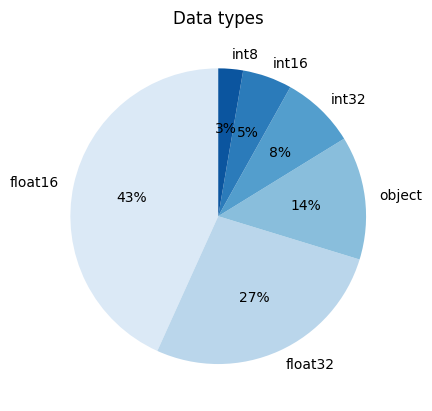

In [62]:
# --------------------
# Variable types
# --------------------
info_previous_application =\
    tools_dataframe.complet_description(previous_application)
print("previous_application")
tools_dataframe.visu_dataTypes(info_previous_application)

<a id='previous_application_preproc'></a>

### <span style='background:#0075bc'><span style='color:white'>previous_application preprocessing</span></span>

<a id='previous_application_outliers'></a>

---
#### <span style='background:#0075bc'><span style='color:white'>previous_application outliers</span></span>

In the EDA we found some erroneous values in DAYS columns, so we will replace them with NaN values

**DAYS_FIRST_DRAWING**

In [63]:
previous_application['DAYS_FIRST_DRAWING'][previous_application['DAYS_FIRST_DRAWING'] == 365243.0] = np.nan

**DAYS_FIRST_DUE**

In [64]:
previous_application['DAYS_FIRST_DUE'][previous_application['DAYS_FIRST_DUE'] == 365243.0] = np.nan

**DAYS_LAST_DUE_1ST_VERSION**

In [65]:
previous_application['DAYS_LAST_DUE_1ST_VERSION'][previous_application['DAYS_LAST_DUE_1ST_VERSION'] == 365243.0] = np.nan

**DAYS_LAST_DUE**

In [66]:
previous_application['DAYS_LAST_DUE'][previous_application['DAYS_LAST_DUE'] == 365243.0] = np.nan

**DAYS_TERMINATION**

In [67]:
previous_application['DAYS_TERMINATION'][previous_application['DAYS_TERMINATION'] == 365243.0] = np.nan

**SELLERPLACE_AREA**

In [68]:
previous_application['SELLERPLACE_AREA'][previous_application['SELLERPLACE_AREA'] == 4000000] = np.nan


In [69]:
# ----------------------------------------------------
# Memory improvement by reducing the size of objects
# ----------------------------------------------------
print("previous_application")
previous_application =\
    tools_preprocessing.reduce_mem_usage(previous_application, verbose=True)

previous_application
-------------------------------------------------------------------------------
Memory usage of dataframe is: 315.38 MB
Memory usage after optimization is : 293.08 MB
Reduction of 7.1%
-------------------------------------------------------------------------------


In [70]:
# Saving bureau_balance after preprocessing
path_sav_prev_app_aftproc = \
    '../P7_scoring_credit/preprocessing/previous_application_aftproc.pkl'
with open(path_sav_prev_app_aftproc, 'wb') as f:
    pickle.dump(previous_application, f, pickle.HIGHEST_PROTOCOL)

<a id='previous_application_feat_eng'></a>

### <span style='background:#0075bc'><span style='color:white'>previous_application feature engineering</span></span>

In [71]:
previous_application = tools_feat_engineering.feat_eng_previous_application(dump_to_pickle = True).main()

########################################################
#        Pre-processing previous_application        #
########################################################

Loading the DataFrame, previous_application, into memory...
Loaded previous_application.csv
Time Taken to load = 0:00:00.553751

Performing Preprocessing and Feature Engineering...
Done.
Time taken = 0:00:05.289546

Aggregating previous applications over SK_ID_CURR...


/home/raquelsp/Documents/Openclassrooms/P7_implementez_modele_scoring/P7_travail/P7_scoring_credit/tools_feat_engineering.py:1058: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  previous_application_aggregated = group_last_3.merge(group_first_3, on = 'SK_ID_CURR', how = 'outer')
/home/raquelsp/Documents/Openclassrooms/P7_implementez_modele_scoring/P7_travail/P7_scoring_credit/tools_feat_engineering.py:1059: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  previous_application_aggregated = previous_application_aggregated.merge(group_

Done aggregations.

Initial Size of previous_application: (1670214, 37)
Size of previous_application after Pre-Processing, Feature Engineering and Aggregation: (338857, 399)

Total Time Taken = 0:00:12.076754

Pickling pre-processed previous_application to previous_application_afteng.pkl
Done.
----------------------------------------------------------------------------------------------------


<a id='previous_application_missing_values'></a>

### <span style='background:#0075bc'><span style='color:white'>previous_application assignment missing values</span></span>

* The **missing values** of the **continuous variables** will be therefore imputed by the **median** of each of these variables.
* The **missing values** of the **categorical variables** will be therefore imputed by the **mode** of each of these variables.

In [72]:
# Load de dataset after feature engineering
path_sav_previous_application_afteng =  '../P7_scoring_credit/preprocessing/previous_application_afteng.pkl'

with open(path_sav_previous_application_afteng, 'rb') as f:
    previous_application_afteng = pickle.load(f)


**Continuous variables**

In [73]:
# Continous variables
cols_num_prevapp = previous_application_afteng.select_dtypes(include=[np.number])\
                                    .columns.to_list()

In [74]:
nb_nan_median = previous_application_afteng[cols_num_prevapp].isna().sum().sum()
print(f'Number of nan in previous_application_afteng before median assignment : {nb_nan_median}')
previous_application_afteng.fillna(previous_application_afteng[cols_num_prevapp].median(), inplace=True)
# Validation
nb_nan_median = previous_application_afteng[cols_num_prevapp].isna().sum().sum()
print(f'Number of nan in previous_application_afteng after median assignment : {nb_nan_median}')

Number of nan in previous_application_afteng before median assignment : 11855599
Number of nan in previous_application_afteng after median assignment : 0


<a id='previous_application_strong_correl'></a>

### <span style='background:#0075bc'><span style='color:white'>previous_application remove strong correlations</span></span>

In this section:
 * The correlation between the numerical variables, Pearson's coefficient, is calculated.
 * The maximum accepted correlation threshold is set at 0.8.
 * The variables whose correlation exceeds the maximum threshold are drop.

In [75]:
# Load file
with open(path_sav_previous_application_afteng, 'rb') as f:
    previous_application_afteng = pickle.load(f)

In [76]:
# ----------------------------------------------------
# Memory improvement by reducing the size of objects
# ----------------------------------------------------
print("previous_application_afteng")
previous_application_afteng =\
    tools_preprocessing.reduce_mem_usage(previous_application_afteng, verbose=True)

previous_application_afteng
-------------------------------------------------------------------------------
Memory usage of dataframe is: 652.46 MB
Memory usage after optimization is : 353.21 MB
Reduction of 45.9%
-------------------------------------------------------------------------------


In [77]:
# CORRELATION MATRIX bureau_merged
# ---------------------------------------------------------------------

threshold = 0.8

# Absolute value correlation matrix to avoid having to manage
# positive and negative correlations separately
corr = previous_application_afteng.corr().abs()

# Only the part above the diagonal is retained so that
# the correlations are taken into account only once (axial symmetry).
corr_triangle = corr.where(np.triu(np.ones(corr.shape), k=1)
                           .astype(np.bool))

/tmp/ipykernel_8612/9274182.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.bool))


In [78]:
# Variables with a Pearson coef > 0.8?
cols_corr_a_supp = [var for var in corr_triangle.columns
                    if any(corr_triangle[var] > threshold)]
print(f'There are {len(cols_corr_a_supp)} variables in previous_application_afteng with strong correlation to be removed.\n')

There are 299 variables in previous_application_afteng with strong correlation to be removed.



In [79]:
# Drop vairables with strong correlation
print(f'previous_application_afteng : {previous_application_afteng.shape}')
previous_application_afteng.drop(columns=cols_corr_a_supp,  inplace=True)
print(f'previous_application_afteng : {previous_application_afteng.shape}')

previous_application_afteng : (338857, 399)
previous_application_afteng : (338857, 100)


In [80]:
# Saving previous_application_afteng ready for ML
path_sav_previous_application_ML = \
    '../P7_scoring_credit/preprocessing/previous_application_ML.pkl'
with open(path_sav_previous_application_ML, 'wb') as f:
    pickle.dump(previous_application_afteng, f, pickle.HIGHEST_PROTOCOL)

**Loading previous_application data after pre-processing and feature engineering**

In [81]:
# Loading previous_application
with open(path_sav_previous_application_ML, 'rb') as df_previous_application_ML:
    previous_application_ML = pickle.load(df_previous_application_ML)
previous_application_ML.shape

(338857, 100)

**Freeing up the memory**

In [82]:
path_processing = '../P7_scoring_credit/preprocessing/'
files_to_remove = ['previous_application_aftproc.pkl', 'previous_application_afteng.pkl']

for file in files_to_remove:
    os.remove(path_processing+file)

In [83]:
del previous_application, previous_application_afteng

<a id='POS_CASH_balance_preprocessing'></a>

## <span style='background:#0085dd'><span style='color:white'>POS_CASH_balance</span></span>

This table contains the Monthly Balance Snapshots of previous Point of Sales and Cash Loans that the applicant had with Home Credit Group. The table contains columns like the status of contract, the number of installments left, etc.

<ol><li>Similar to bureau_balance table, this table also has time based features. So we start off by computing the EDAs on CNT_INSTALMENT and CNT_INSTALMENT_FUTURE features. </li>
    <li>We create some domain based features next.</li>
    <li>We then aggregate the data over SK_ID_PREV. For this aggregation, we do it in 3 ways. Firstly we aggregate the whole data over SK_ID_PREV. We also aggregate the data for last 2 years separately and rest of the years separately. Finally, we also aggregate the data different Contract types, i.e. Active and Completed.</li>
    <li>Next, we aggregate the data over SK_ID_CURR, for it to be merged with main table.</li></ol>

In [84]:
# -----------------------------
# Files upload:
# -----------------------------
# Data from previous loans at Home Credit
POS_CASH_balance = pd.read_csv('POS_CASH_balance.csv',
                               low_memory=False, encoding='utf-8')

In [85]:
# ----------------------------------------------------
# Memory improvement by reducing the size of objects
# ----------------------------------------------------
print("POS_CASH_balance")
POS_CASH_balance =\
    tools_preprocessing.reduce_mem_usage(POS_CASH_balance, verbose=True)

POS_CASH_balance
-------------------------------------------------------------------------------
Memory usage of dataframe is: 610.43 MB
Memory usage after optimization is : 238.45 MB
Reduction of 60.9%
-------------------------------------------------------------------------------


No outliers were found for this file during the exploratory analysis.

In [86]:
# Saving bureau_balance after preprocessing
path_sav_POS_CASH_aftproc = \
    '../P7_scoring_credit/preprocessing/POS_CASH_aftproc.pkl'
with open(path_sav_POS_CASH_aftproc, 'wb') as f:
    pickle.dump(POS_CASH_balance, f, pickle.HIGHEST_PROTOCOL)

<a id='POS_CASH_balance_feat_eng'></a>

### <span style='background:#0075bc'><span style='color:white'>POS_CASH_balance feature engineering</span></span>

In [87]:
POS_CASH_balance = tools_feat_engineering.feat_eng_POS_CASH_balance(dump_to_pickle = True).main()

#########################################################
#          Pre-processing POS_CASH_balance          #
#########################################################

Loading the DataFrame, POS_CASH_balance, into memory...
Loaded POS_CASH_balance.csv
Time Taken to load = 0:00:00.165823

Starting Data Cleaning and Feature Engineering...
Done.
Time Taken = 0:03:22.673680

Aggregations over SK_ID_PREV...
Done.
Time Taken = 0:00:11.902316

Aggregation over SK_ID_CURR...

Done preprocessing POS_CASH_balance.

Initial Size of POS_CASH_balance: (10001358, 8)
Size of POS_CASH_balance after Pre-Processing, Feature Engineering and Aggregation: (337252, 188)

Total Time Taken = 0:03:38.731118

Pickling pre-processed POS_CASH_balance to POS_CASH_balance_afteng.pkl
Done.
----------------------------------------------------------------------------------------------------


<a id='POS_CASH_balance_missing_values'></a>

### <span style='background:#0075bc'><span style='color:white'>POS_CASH_balance assignment missing values</span></span>

* The **missing values** of the **continuous variables** will be therefore imputed by the **median** of each of these variables.
* The **missing values** of the **categorical variables** will be therefore imputed by the **mode** of each of these variables.

In [88]:
# Load de dataset after feature engineering
path_sav_POS_CASH_balance_afteng =  '../P7_scoring_credit/preprocessing/POS_CASH_balance_afteng.pkl'

with open(path_sav_POS_CASH_balance_afteng, 'rb') as f:
    POS_CASH_balance_afteng = pickle.load(f)


**Continuous variables**

In [89]:
# Continous variables
cols_num_poscash = POS_CASH_balance_afteng.select_dtypes(include=[np.number])\
                                    .columns.to_list()

In [90]:
nb_nan_median = POS_CASH_balance_afteng[cols_num_poscash].isna().sum().sum()
print(f'Number of nan in POS_CASH_balance_afteng before median assignment : {nb_nan_median}')
POS_CASH_balance_afteng.fillna(POS_CASH_balance_afteng[cols_num_poscash].median(), inplace=True)
# Validation
nb_nan_median = POS_CASH_balance_afteng[cols_num_poscash].isna().sum().sum()
print(f'Number of nan in POS_CASH_balance_afteng after median assignment : {nb_nan_median}')

Number of nan in POS_CASH_balance_afteng before median assignment : 12465974
Number of nan in POS_CASH_balance_afteng after median assignment : 0


In [91]:
# Saving POS_CASH_balance_afteng
with open(path_sav_POS_CASH_balance_afteng, 'wb') as f:
    pickle.dump(POS_CASH_balance_afteng, f, pickle.HIGHEST_PROTOCOL)

<a id='POS_CASH_balance_strong_correl'></a>

### <span style='background:#0075bc'><span style='color:white'>POS_CASH_balance remove strong correlations</span></span>

In this section:
 * The correlation between the numerical variables, Pearson's coefficient, is calculated.
 * The maximum accepted correlation threshold is set at 0.8.
 * The variables whose correlation exceeds the maximum threshold are drop.

In [92]:
# Load file
with open(path_sav_POS_CASH_balance_afteng, 'rb') as f:
    POS_CASH_balance_afteng = pickle.load(f)

In [93]:
# ----------------------------------------------------
# Memory improvement by reducing the size of objects
# ----------------------------------------------------
print("POS_CASH_balance_afteng")
POS_CASH_balance_afteng =\
    tools_preprocessing.reduce_mem_usage(POS_CASH_balance_afteng, verbose=True)

POS_CASH_balance_afteng
-------------------------------------------------------------------------------
Memory usage of dataframe is: 354.43 MB
Memory usage after optimization is : 147.31 MB
Reduction of 58.4%
-------------------------------------------------------------------------------


In [94]:
# CORRELATION MATRIX bureau_merged
# ---------------------------------------------------------------------

threshold = 0.8

# Absolute value correlation matrix to avoid having to manage
# positive and negative correlations separately
corr = POS_CASH_balance_afteng.corr().abs()

# Only the part above the diagonal is retained so that
# the correlations are taken into account only once (axial symmetry).
corr_triangle = corr.where(np.triu(np.ones(corr.shape), k=1)
                           .astype(np.bool))

/tmp/ipykernel_8612/3211964005.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.bool))


In [95]:
# Variables with a Pearson coef > 0.8?
cols_corr_a_supp = [var for var in corr_triangle.columns
                    if any(corr_triangle[var] > threshold)]
print(f'There are {len(cols_corr_a_supp)} variables in POS_CASH_balance_afteng with strong correlation to be removed.\n')

There are 160 variables in POS_CASH_balance_afteng with strong correlation to be removed.



In [96]:
# Drop vairables with strong correlation
print(f'POS_CASH_balance_afteng : {POS_CASH_balance_afteng.shape}')
POS_CASH_balance_afteng.drop(columns=cols_corr_a_supp,  inplace=True)
print(f'POS_CASH_balance_afteng : {POS_CASH_balance_afteng.shape}')

POS_CASH_balance_afteng : (337252, 188)
POS_CASH_balance_afteng : (337252, 28)


In [97]:
# Saving POS_CASH_balance_afteng ready for ML
path_sav_POS_CASH_balance_ML = \
    '../P7_scoring_credit/preprocessing/POS_CASH_balance_ML.pkl'
with open(path_sav_POS_CASH_balance_ML, 'wb') as f:
    pickle.dump(POS_CASH_balance_afteng, f, pickle.HIGHEST_PROTOCOL)

**Loading POS_CASH_balance data after pre-processing and feature engineering**

In [98]:
# Loading bureau_merged
with open(path_sav_POS_CASH_balance_ML, 'rb') as df_POS_CASH_balance_ML:
    POS_CASH_balance_ML = pickle.load(df_POS_CASH_balance_ML)
POS_CASH_balance_ML.shape

(337252, 28)

**Freeing up the memory**

In [99]:
path_processing = '../P7_scoring_credit/preprocessing/'
files_to_remove = ['POS_CASH_aftproc.pkl', 'POS_CASH_balance_afteng.pkl']

for file in files_to_remove:
    os.remove(path_processing+file)

In [100]:
del POS_CASH_balance, POS_CASH_balance_afteng

<a id='installments_payments_preprocessing'></a>

## <span style='background:#0085dd'><span style='color:white'>installments_payments</span></span>

This table contains the details about each installment of client's previous credits with Home Credit Group.
<ol><li>We start by sorting the data first by SK_ID_CURR and SK_ID_PREV, and then by NUM_INSTALMENT_NUMBER. This brings the latest installments in the end.</li>
    <li>We create some features, such as the number of days the payment was delayed, the difference in amount of payment required vs paid, etc.</li>
    <li>Next we aggregate these rows over SK_ID_PREV, such that each client's previous loan gets one row. These aggregations are done in three ways, first overall aggregations, second we aggregate only those installments which were in the last 365 days, and lastly, we aggregate the first 5 installments of every loan. This will help us to capture the starting behaviour, the latest behaviour and the overall behaviour of the client's installments payments.</li>
    <li>Now to merge this table with main table, we aggregate the data over SK_ID_CURR.</li>
    </ol>

In [101]:
# -----------------------------
# Files upload:
# -----------------------------
# Data from previous loans at Home Credit
installments_payments = pd.read_csv('installments_payments.csv',
                                    low_memory=False, encoding='utf-8')

In [102]:
# ----------------------------------------------------
# Memory improvement by reducing the size of objects
# ----------------------------------------------------
print("installments_payments")
installments_payments =\
    tools_preprocessing.reduce_mem_usage(installments_payments, verbose=True)

installments_payments
-------------------------------------------------------------------------------
Memory usage of dataframe is: 830.41 MB
Memory usage after optimization is : 311.40 MB
Reduction of 62.5%
-------------------------------------------------------------------------------


No outliers were found for this file during the exploratory analysis.

In [103]:
# Saving bureau_balance after preprocessing
path_sav_instpay_aftproc = \
    '../P7_scoring_credit/preprocessing/installments_payments_aftproc.pkl'
with open(path_sav_instpay_aftproc, 'wb') as f:
    pickle.dump(installments_payments, f, pickle.HIGHEST_PROTOCOL)

<a id='installments_payments_feat_eng'></a>

### <span style='background:#0075bc'><span style='color:white'>installments_payments feature engineering</span></span>

In [104]:
installments_payments = tools_feat_engineering.feat_eng_installments_payments(dump_to_pickle = True).main()

#####################################################
#        Pre-processing installments_payments       #
#####################################################

Loading the DataFrame installments_payments into memory...
Loaded installments_payments.csv
Time Taken to load = 0:00:00.070035

Starting Data Pre-processing and Feature Engineering...
Done.
Time Taken = 0:00:10.981419

Performing Aggregations over SK_ID_PREV...
Done.
Time Taken = 0:00:10.368742

Aggregations over SK_ID_CURR...

Done preprocessing installments_payments.

Initial Size of installments_payments: (13605401, 8)
Size of installments_payments after Pre-Processing, Feature Engineering and Aggregation: (339587, 101)

Total Time Taken = 0:00:23.534150

Pickling pre-processed installments_payments to installments_payments_afteng.pkl
Done.
----------------------------------------------------------------------------------------------------


<a id='installments_payments_missing_values'></a>

### <span style='background:#0075bc'><span style='color:white'>installments_payments assignment missing values</span></span>

* The **missing values** of the **continuous variables** will be therefore imputed by the **median** of each of these variables.
* The **missing values** of the **categorical variables** will be therefore imputed by the **mode** of each of these variables.

In [105]:
# Load de dataset after feature engineering
path_sav_installments_payments_afteng =  '../P7_scoring_credit/preprocessing/installments_payments_afteng.pkl'

with open(path_sav_installments_payments_afteng, 'rb') as f:
    installments_payments_afteng = pickle.load(f)


**Continuous variables**

In [106]:
# Continous variables
cols_num_poscash = installments_payments_afteng.select_dtypes(include=[np.number])\
                                    .columns.to_list()

In [107]:
nb_nan_median = installments_payments_afteng[cols_num_poscash].isna().sum().sum()
print(f'Number of nan in installments_payments before median assignment : {nb_nan_median}')
installments_payments_afteng.fillna(installments_payments_afteng[cols_num_poscash].median(), inplace=True)
# Validation
nb_nan_median = installments_payments_afteng[cols_num_poscash].isna().sum().sum()
print(f'Number of nan in installments_payments_afteng after median assignment : {nb_nan_median}')

Number of nan in installments_payments before median assignment : 2089073
Number of nan in installments_payments_afteng after median assignment : 0


In [108]:
# Saving installments_payments_afteng
with open(path_sav_installments_payments_afteng, 'wb') as f:
    pickle.dump(installments_payments_afteng, f, pickle.HIGHEST_PROTOCOL)

<a id='installments_payments_strong_correl'></a>

### <span style='background:#0075bc'><span style='color:white'>installments_payments remove strong correlations</span></span>

In this section:
 * The correlation between the numerical variables, Pearson's coefficient, is calculated.
 * The maximum accepted correlation threshold is set at 0.8.
 * The variables whose correlation exceeds the maximum threshold are drop.

In [109]:
# Load file
with open(path_sav_installments_payments_afteng, 'rb') as f:
    installments_payments_afteng = pickle.load(f)

In [110]:
# ----------------------------------------------------
# Memory improvement by reducing the size of objects
# ----------------------------------------------------
print("installments_payments_afteng")
installments_payments_afteng =\
    tools_preprocessing.reduce_mem_usage(installments_payments_afteng, verbose=True)

installments_payments_afteng
-------------------------------------------------------------------------------
Memory usage of dataframe is: 148.97 MB
Memory usage after optimization is : 104.61 MB
Reduction of 29.8%
-------------------------------------------------------------------------------


In [111]:
# CORRELATION MATRIX bureau_merged
# ---------------------------------------------------------------------

threshold = 0.8

# Absolute value correlation matrix to avoid having to manage
# positive and negative correlations separately
corr = installments_payments_afteng.corr().abs()

# Only the part above the diagonal is retained so that
# the correlations are taken into account only once (axial symmetry).
corr_triangle = corr.where(np.triu(np.ones(corr.shape), k=1)
                           .astype(np.bool))

/tmp/ipykernel_8612/3065457683.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.bool))


In [112]:
# Variables with a Pearson coef > 0.8?
cols_corr_a_supp = [var for var in corr_triangle.columns
                    if any(corr_triangle[var] > threshold)]
print(f'There are {len(cols_corr_a_supp)} variables in installments_payments_afteng with strong correlation to be removed.\n')

There are 53 variables in installments_payments_afteng with strong correlation to be removed.



In [113]:
# Drop vairables with strong correlation
print(f'installments_payments_afteng : {installments_payments_afteng.shape}')
installments_payments_afteng.drop(columns=cols_corr_a_supp,  inplace=True)
print(f'installments_payments_afteng : {installments_payments_afteng.shape}')

installments_payments_afteng : (339587, 101)
installments_payments_afteng : (339587, 48)


In [114]:
# Saving installments_payments_afteng ready for ML
path_sav_installments_payments_ML = \
    '../P7_scoring_credit/preprocessing/installments_payments_ML.pkl'
with open(path_sav_installments_payments_ML, 'wb') as f:
    pickle.dump(installments_payments_afteng, f, pickle.HIGHEST_PROTOCOL)

**Loading installments_payments data after pre-processing and feature engineering**

In [115]:
# Loading bureau_merged
with open(path_sav_installments_payments_ML, 'rb') as df_installments_payments_ML:
    installments_payments_ML = pickle.load(df_installments_payments_ML)
installments_payments_ML.shape

(339587, 48)

**Freeing up the memory**

In [116]:
path_processing = '../P7_scoring_credit/preprocessing/'
files_to_remove = ['installments_payments_aftproc.pkl', 'installments_payments_afteng.pkl']

for file in files_to_remove:
    os.remove(path_processing+file)

In [117]:
del installments_payments, installments_payments_afteng

<a id='cc_balance_preprocessing'></a>

## <span style='background:#0085dd'><span style='color:white'>credit_card_balance</span></span>

This table contains information about the previous credit cards that the client had with Home Credit Group.

<ol><li>We start off with removing an erroneous value, and then we proceed to feature engineering.</li>
    <li>We create some domain based features such as total drawings, number of drawings, balance to limit ratio, payment done to minimum payment required difference, etc.</li>
    <li>This table also contains all these data monthwise, so we calculate the EDAs for some of the features of this table too.</li>
    <li>For aggregations, we first aggregate over SK_ID_PREV. Here we aggregate on three bases. Firstly, we do overall aggregations. We also do aggregations for last 2 years separately and the rest of the years. Finally we aggregate over SK_ID_PREV for categorical variable NAME_CONTRACT_TYPE. </li>
    <li>For aggregation over SK_ID_CURR, we saw from the EDA that most of the current clients just had 1 credit card previously, so we do simple mean aggregations over SK_ID_CURR.</li></ol>

In [118]:
# -----------------------------
# Files upload:
# -----------------------------
# Data from previous loans at Home Credit
cc_balance = pd.read_csv('credit_card_balance.csv',
                         low_memory=False, encoding='utf-8')

In [119]:
# ----------------------------------------------------
# Memory improvement by reducing the size of objects
# ----------------------------------------------------
print("cc_balance")
cc_balance =\
    tools_preprocessing.reduce_mem_usage(cc_balance, verbose=True)

cc_balance
-------------------------------------------------------------------------------
Memory usage of dataframe is: 673.88 MB
Memory usage after optimization is : 289.33 MB
Reduction of 57.1%
-------------------------------------------------------------------------------


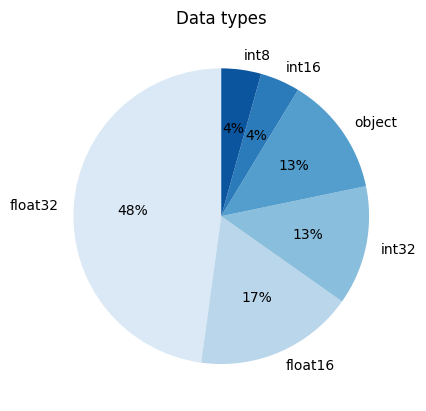

In [120]:
# --------------------
# Variable types
# --------------------
info_cc_balance =\
    tools_dataframe.complet_description(cc_balance)
tools_dataframe.visu_dataTypes(info_cc_balance)

<a id='cc_balance_preproc'></a>

### <span style='background:#0075bc'><span style='color:white'>credit_card_balance preprocessing</span></span>

**DAYS_FIRST_DRAWING**

In [121]:
#there is one abruptly large value for AMT_PAYMENT_CURRENT
cc_balance['AMT_PAYMENT_CURRENT'][cc_balance['AMT_PAYMENT_CURRENT'] > 4000000] = np.nan

**MISSING_VALS_TOTAL_CC**

In [122]:
cc_balance['MISSING_VALS_TOTAL_CC'] = cc_balance.isna().sum(axis = 1)

**DAYS_FIRST_DRAWING**

In [123]:
#making the MONTHS_BALANCE Positive
cc_balance['MONTHS_BALANCE'] = np.abs(cc_balance['MONTHS_BALANCE'])

In [124]:
# ----------------------------------------------------
# Memory improvement by reducing the size of objects
# ----------------------------------------------------
print("cc_balance")
cc_balance =\
    tools_preprocessing.reduce_mem_usage(cc_balance, verbose=True)

cc_balance
-------------------------------------------------------------------------------
Memory usage of dataframe is: 318.63 MB
Memory usage after optimization is : 292.99 MB
Reduction of 8.0%
-------------------------------------------------------------------------------


In [125]:
# Saving cc_balance after preprocessing
path_sav_cc_balance_aftproc = \
    '../P7_scoring_credit/preprocessing/cc_balance_aftproc.pkl'
with open(path_sav_cc_balance_aftproc, 'wb') as f:
    pickle.dump(cc_balance, f, pickle.HIGHEST_PROTOCOL)

<a id='cc_balance_feat_eng'></a>

### <span style='background:#0075bc'><span style='color:white'>credit_card_balance feature engineering</span></span>

In [126]:
cc_balance = tools_feat_engineering.feat_eng_cc_balance(dump_to_pickle = True).main()

#########################################################
#        Pre-processing credit_card_balance.csv         #
#########################################################

Loading the DataFrame, credit_card_balance.csv, into memory...
Loaded credit_card_balance.csv
Time Taken to load = 0:00:00.097142

Starting Preprocessing and Feature Engineering...
Done.
Time Taken = 0:00:53.137029

Aggregating the DataFrame, first over SK_ID_PREv, then over SK_ID_CURR

Done preprocessing credit_card_balance.

Initial Size of credit_card_balance: (3840312, 24)
Size of credit_card_balance after Pre-Processing, Feature Engineering and Aggregation: (103558, 249)

Total Time Taken = 0:00:59.294238

Pickling pre-processed credit_card_balance to cc_balance_afteng.pkl
Done.
----------------------------------------------------------------------------------------------------


<a id='cc_balance_missing_values'></a>

### <span style='background:#0075bc'><span style='color:white'>credit_card_balance assignment missing values</span></span>

* The **missing values** of the **continuous variables** will be therefore imputed by the **median** of each of these variables.
* The **missing values** of the **categorical variables** will be therefore imputed by the **mode** of each of these variables.

In [127]:
# Load de dataset after feature engineering
path_sav_cc_balance_afteng =  '../P7_scoring_credit/preprocessing/cc_balance_afteng.pkl'

with open(path_sav_cc_balance_afteng, 'rb') as f:
    cc_balance_afteng = pickle.load(f)


**Continuous variables**

In [128]:
# Continous variables
cols_num_cc_bal = cc_balance_afteng.select_dtypes(include=[np.number])\
                                    .columns.to_list()

In [129]:
nb_nan_median = cc_balance_afteng[cols_num_cc_bal].isna().sum().sum()
print(f'Number of nan in cc_balance_afteng before median assignment : {nb_nan_median}')
cc_balance_afteng.fillna(cc_balance_afteng[cols_num_cc_bal].median(), inplace=True)
# Validation
nb_nan_median = cc_balance_afteng[cols_num_cc_bal].isna().sum().sum()
print(f'Number of nan in cc_balance_afteng after median assignment : {nb_nan_median}')

Number of nan in cc_balance_afteng before median assignment : 8503730
Number of nan in cc_balance_afteng after median assignment : 0


In [130]:
# Saving cc_balance_afteng
with open(path_sav_cc_balance_afteng, 'wb') as f:
    pickle.dump(cc_balance_afteng, f, pickle.HIGHEST_PROTOCOL)

<a id='cc_balance_strong_correl'></a>

### <span style='background:#0075bc'><span style='color:white'>credit_card_balance remove strong correlations</span></span>

In this section:
 * The correlation between the numerical variables, Pearson's coefficient, is calculated.
 * The maximum accepted correlation threshold is set at 0.8.
 * The variables whose correlation exceeds the maximum threshold are drop.

In [131]:
# Load file
with open(path_sav_cc_balance_afteng, 'rb') as f:
    cc_balance_afteng = pickle.load(f)

In [132]:
# ----------------------------------------------------
# Memory improvement by reducing the size of objects
# ----------------------------------------------------
print("cc_balance_afteng")
cc_balance_afteng =\
    tools_preprocessing.reduce_mem_usage(cc_balance_afteng, verbose=True)

cc_balance_afteng
-------------------------------------------------------------------------------
Memory usage of dataframe is: 152.49 MB
Memory usage after optimization is : 85.13 MB
Reduction of 44.2%
-------------------------------------------------------------------------------


In [133]:
# CORRELATION MATRIX bureau_merged
# ---------------------------------------------------------------------

threshold = 0.8

# Absolute value correlation matrix to avoid having to manage
# positive and negative correlations separately
corr = cc_balance_afteng.corr().abs()

# Only the part above the diagonal is retained so that
# the correlations are taken into account only once (axial symmetry).
corr_triangle = corr.where(np.triu(np.ones(corr.shape), k=1)
                           .astype(np.bool))

/tmp/ipykernel_8612/1598424546.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.bool))


In [134]:
# Variables with a Pearson coef > 0.8?
cols_corr_a_supp = [var for var in corr_triangle.columns
                    if any(corr_triangle[var] > threshold)]
print(f'There are {len(cols_corr_a_supp)} variables in cc_balance_afteng with strong correlation to be removed.\n')

There are 160 variables in cc_balance_afteng with strong correlation to be removed.



In [135]:
# Drop vairables with strong correlation
print(f'cc_balance_afteng : {cc_balance_afteng.shape}')
cc_balance_afteng.drop(columns=cols_corr_a_supp,  inplace=True)
print(f'cc_balance_afteng : {cc_balance_afteng.shape}')

cc_balance_afteng : (103558, 249)
cc_balance_afteng : (103558, 89)


In [136]:
# Saving cc_balance_afteng ready for ML
path_sav_cc_balance_ML = \
    '../P7_scoring_credit/preprocessing/cc_balance_ML.pkl'
with open(path_sav_cc_balance_ML, 'wb') as f:
    pickle.dump(cc_balance_afteng, f, pickle.HIGHEST_PROTOCOL)

**Loading cc_balance_afteng data after pre-processing and feature engineering**

In [137]:
# Loading bureau_merged
with open(path_sav_cc_balance_ML, 'rb') as df_cc_balance_ML:
    cc_balance_ML = pickle.load(df_cc_balance_ML)
cc_balance_ML.shape

(103558, 89)

**Freeing up the memory**

In [138]:
path_processing = '../P7_scoring_credit/preprocessing/'
files_to_remove = ['cc_balance_aftproc.pkl', 'cc_balance_afteng.pkl']

for file in files_to_remove:
    os.remove(path_processing+file)

In [139]:
del cc_balance, cc_balance_afteng

<a id='previous_loans_other_than_Home_Credit'></a>

---
---

# <span style='background:#2994ff'><span style='color:white'>**Data from previous loans in financial organisations other than Home Credit Group** </span></span>



The 2 files concerned by previous loans in financial organisations other than Home Credit Group are :
* **bureau_balance.csv**
* **bureau.csv**


These tables contain the information related to the client's previous credits which were not with Home Credit Group, and were reported by Credit Bureau Department. 
<ol><li><b>bureau_balance</b>
    <ol><li>First off, the bureau_balance table contains three fields, i.e. SK_ID_BUREAU, MONTHS_BALANCE and STATUS.</li>
        <li>Since the Status follows somewhat ordinal behaviour, we start by label encoding it.</li>
        <li>Next, some features are created such as weighted status, which is obtained by dividing the status by the MONTHS_BALANCE.</li>
        <li>Since the data contains the timeseries, we also calculate the Exponential Weighted Moving Average of the Status and Weighted Status fields.</li>
        <li>Finally, we aggregate the data over SK_ID_BUREAU, in such a way that we first aggregate it over all the data, and after that we also aggregate over the last 2 years. These 2 years would depict the more recent behaviour of the clients.</li>
        <li>The aggregations performed are based on Domain Knowledge, such as mean, min, max, sum, count, etc. For EDA features, we only take the last/most recent values, as they somewhat contain the trend of all the previous values.</li></ol>
    <li><b>bureau</b>
    <ol><li>Firstly, we merge the bureau table with the aggregated bureau_balance table from previous step, on SK_ID_BUREAU.</li>
        <li>We replace some erroneous values with NaN values. We saw some loans dating back to as long as 100 years ago. We believe they wouldn't really tell much about client's recent behaviour, so we remove them and only keep the loans in the period of 50 years.</li>
        <li>We create some features by multiplications, divisions, subtractions of raw features, based on domain knowledge, such as Credit duration, annutiy to credit ratio, etc.</li>
        <li>The categorical features are one-hot encoded.
        <li>To merge these to main table, i.e. application_train, we aggregate this table over SK_ID_CURR. We perform the aggregations again in two ways. We aggregate the credits based on the CREDIT_ACTIVE category, where we aggregate for two most popular categories separately, i.e. Active, and Closed. Later we aggregate for the remaining categories too, and merge these. We aggregated the whole data overall too. The aggregations performed are sum, mean, min, max, last, etc.</li>
        </ol></li></ol>

In [140]:
# -----------------------------
# Files upload:
# -----------------------------

# Data from previous loans in financial organisations other than Home Credit
bureau_balance = pd.read_csv('bureau_balance.csv', low_memory=False,
                             encoding='utf-8')
bureau = pd.read_csv('bureau.csv', low_memory=False, encoding='utf-8')

<a id='bureau_balance_preprocessing'></a>

## <span style='background:#0085dd'><span style='color:white'>bureau_balance</span></span>

This file contains information about monthly balances of previous loans in the Credit Bureau.
This table has one row for each month of history of each previous credit reported to the Credit Bureau - i.e. the table has (#loans in sample * # of relative previous credits * # of months where we have an observable history for previous credits) rows.

In [141]:
# ----------------------------------------------------
# Memory improvement by reducing the size of objects
# ----------------------------------------------------
print("bureau_balance")
bureau_balance =\
    tools_preprocessing.reduce_mem_usage(bureau_balance, verbose=True)

bureau_balance
-------------------------------------------------------------------------------
Memory usage of dataframe is: 624.85 MB
Memory usage after optimization is : 338.46 MB
Reduction of 45.8%
-------------------------------------------------------------------------------


<a id='bureau_balance_preproc'></a>

### <span style='background:#0075bc'><span style='color:white'>bureau_balance preprocessing</span></span>

Statut du prêt du Credit Bureau durant le mois (actif ou fermé ou DPD0-30...) :
- C => fermé
- X => statut inconnu
- 0 => pas de DPD
- 1 => DPD maximal durant le mois entre 1-30
- 2 signifie DPD 31-60
- ../.
- 5 ==> DPD 120+ ou vendu ou amorti ]

L'encodage consistera à donner à la valeur 0 puis d'incrémenter les valeurs, en plaçant X, la valeur inconnue au milieu du tableau des valeurs en lui donnant le bénéfice du doute et 0 pour 0 pas de défaillance.

In [142]:
#as we saw from EDA, bureau_balance has a variable called STATUS, which describes about the status of loan.
        #it has 7 labels, we will label encode them
        #so we give C as 0, and rest increasing
        #also we will give X the benefit of doubt and keep it as middle value
dict_for_status = { 'C': 0, '0': 1, '1': 2, '2': 3, 'X': 4, '3': 5, '4': 6,
                   '5': 7}
bureau_balance['STATUS'] = bureau_balance['STATUS'].map(dict_for_status)

In [143]:
#converting months to positive
bureau_balance['MONTHS_BALANCE'] = np.abs(bureau_balance['MONTHS_BALANCE'])
#weighing the status with the months_balance
bureau_balance['WEIGHTED_STATUS'] = bureau_balance.STATUS / (bureau_balance.MONTHS_BALANCE + 1)

In [144]:
# ----------------------------------------------------
# Memory improvement by reducing the size of objects
# ----------------------------------------------------
print("bureau_balance")
bureau_balance =\
    tools_preprocessing.reduce_mem_usage(bureau_balance, verbose=True)

bureau_balance
-------------------------------------------------------------------------------
Memory usage of dataframe is: 546.74 MB
Memory usage after optimization is : 208.28 MB
Reduction of 61.9%
-------------------------------------------------------------------------------


In [145]:
# Saving bureau_balance after preprocessing
path_sav_bureaubal_aftproc = \
    '../P7_scoring_credit/preprocessing/bureaubal_aftproc.pkl'
with open(path_sav_bureaubal_aftproc, 'wb') as f:
    pickle.dump(bureau_balance, f, pickle.HIGHEST_PROTOCOL)

<a id='bureau_balance_feat_eng'></a>

### <span style='background:#0075bc'><span style='color:white'>bureau_balance feature engineering</span></span>

In [146]:
bureau_balance = tools_feat_engineering.feat_eng_bureau_balance(dump_to_pickle = True).main()

########################################################
#          Feature engineering bureau_balance          #
########################################################

Loading the DataFrame, bureau_balance, into memory...
Loaded bureau_balance.csv
Time Taken to load = 0:00:00.034790

Starting Feature Engineering...
Halfway through. A little bit more patience...
Total Time Elapsed = 0:05:17.455895

Pickling bureau_balance after feature engineering to bureau_balance_aft_feat_eng.pkl
Done.


<a id='bureau_balance_assing_missing_values'></a>

### <span style='background:#0075bc'><span style='color:white'>bureau_balance assignment missing values</span></span>

* The **missing values** of the **continuous variables** will be therefore imputed by the **median** of each of these variables.
* The **missing values** of the **categorical variables** will be therefore imputed by the **mode** of each of these variables.

In [147]:
# Load de dataset after feature engineering
path_sav_bureaubal_aft_feateng =  '../P7_scoring_credit/preprocessing/bureau_balance_aft_feat_eng.pkl'

with open(path_sav_bureaubal_aft_feateng, 'rb') as f:
    aggr_bureau_balance = pickle.load(f)


**Continuous variables**

In [148]:
# Continous variables
cols_num_bureaub = aggr_bureau_balance.select_dtypes(include=[np.number])\
                                    .columns.to_list()

In [149]:
nb_nan_median = aggr_bureau_balance[cols_num_bureaub].isna().sum().sum()
print(f'Number of nan in aggr_bureau_balance before median assignment : {nb_nan_median}')
aggr_bureau_balance.fillna(aggr_bureau_balance[cols_num_bureaub].median(), inplace=True)
# Validation
nb_nan_median = aggr_bureau_balance[cols_num_bureaub].isna().sum().sum()
print(f'Number of nan in aggr_bureau_balance after median assignment : {nb_nan_median}')

Number of nan in aggr_bureau_balance before median assignment : 6829060
Number of nan in aggr_bureau_balance after median assignment : 0


In [150]:
# Saving aggr_bureau_balance
with open(path_sav_bureaubal_aft_feateng, 'wb') as f:
    pickle.dump(aggr_bureau_balance, f, pickle.HIGHEST_PROTOCOL)

**Freeing up the memory**

In [151]:
path_processing = '../P7_scoring_credit/preprocessing/'
files_to_remove = ['bureaubal_aftproc.pkl']

for file in files_to_remove:
    os.remove(path_processing+file)

In [152]:
del bureau_balance, aggr_bureau_balance

<a id='bureau_preprocessing_feat_eng'></a>

## <span style='background:#0085dd'><span style='color:white'>bureau</span></span>

In [153]:
# ----------------------------------------------------
# Memory improvement by reducing the size of objects
# ----------------------------------------------------
print("bureau")
bureau =\
    tools_preprocessing.reduce_mem_usage(bureau, verbose=True)

bureau
-------------------------------------------------------------------------------
Memory usage of dataframe is: 222.62 MB
Memory usage after optimization is : 112.95 MB
Reduction of 49.3%
-------------------------------------------------------------------------------


<a id='bureau'></a>

### <span style='background:#0075bc'><span style='color:white'>bureau preprocessing</span></span>

<a id='bureau_outliers'></a>

---
#### <span style='background:#0075bc'><span style='color:white'>bureau outliers</span></span>

From the EDA we saw some erroneous values in DAYS Fields, we will remove those there are some loans which ended about very long ago, around 100 years ago.
Only those loans which have ended in past 50 years will be retained.

**DAYS_CREDIT_ENDDATE**

In [154]:
# Remove information related to loans that ended more than 50 years ago
bureau['DAYS_CREDIT_ENDDATE'][bureau['DAYS_CREDIT_ENDDATE'] > -50*365] = np.nan

**DAYS_ENDDATE_FACT**

In [155]:
# Remove information related to loans that ended more than 50 years ago
bureau['DAYS_ENDDATE_FACT'][bureau['DAYS_ENDDATE_FACT'] > -50*365] = np.nan

**DAYS_CREDIT_UPDATE**

In [156]:
# Remove information related to loans that ended more than 50 years ago
bureau['DAYS_CREDIT_UPDATE'][bureau['DAYS_CREDIT_UPDATE'] > -50*365] = np.nan

In [157]:
# ----------------------------------------------------
# Memory improvement by reducing the size of objects
# ----------------------------------------------------
print("bureau")
bureau = tools_preprocessing.reduce_mem_usage(bureau, verbose=True)

bureau
-------------------------------------------------------------------------------
Memory usage of dataframe is: 119.49 MB
Memory usage after optimization is : 109.67 MB
Reduction of 8.2%
-------------------------------------------------------------------------------


In [158]:
# Saving bureau after preprocessing
path_sav_bureau_aftproc = \
    '../P7_scoring_credit/preprocessing/bureau_aftproc.pkl'
with open(path_sav_bureau_aftproc, 'wb') as f:
    pickle.dump(bureau, f, pickle.HIGHEST_PROTOCOL)

<a id='bureau_feat_eng'></a>

### <span style='background:#0075bc'><span style='color:white'>bureau feature engineering</span></span>

In [159]:
bureau = tools_feat_engineering.feat_eng_bureau(dump_to_pickle = True).main()

###############################################
#          Feature engineering bureau         #
###############################################

Loading the DataFrame, bureau, into memory...
Loaded bureau
Time Taken to load = 0:00:00.092130

Starting Data Cleaning and Feature Engineering...
Done preprocessing bureau and bureau_balance.

Initial Size of bureau: (1716428, 17)
Size of bureau and bureau_balance after Merging, Pre-Processing, Feature Engineering and Aggregation: (305811, 242)

Total Time Taken = 0:00:05.699834

Pickling pre-processed bureau and bureau_balance to bureau_merged_aggregated.pkl
Done.
----------------------------------------------------------------------------------------------------


<a id='bureau_merged_assing_missing_values'></a>

### <span style='background:#0075bc'><span style='color:white'>bureau_merged assignment missing values</span></span>

* The **missing values** of the **continuous variables** will be therefore imputed by the **median** of each of these variables.
* The **missing values** of the **categorical variables** will be therefore imputed by the **mode** of each of these variables.

In [160]:
# Load de dataset after feature engineering
path_sav_bureau_merged_aggregated =  '../P7_scoring_credit/preprocessing/bureau_merged_aggregated.pkl'

with open(path_sav_bureau_merged_aggregated, 'rb') as f:
    bureau_merged_aggregated = pickle.load(f)


**Continuous variables**

In [161]:
# Continous variables
cols_num_bureaumerg = bureau_merged_aggregated.select_dtypes(include=[np.number])\
                                    .columns.to_list()

In [162]:
nb_nan_median = bureau_merged_aggregated[cols_num_bureaumerg].isna().sum().sum()
print(f'Number of nan in bureau_merged_aggregated before median assignment : {nb_nan_median}')
bureau_merged_aggregated.fillna(bureau_merged_aggregated[cols_num_bureaumerg].median(), inplace=True)
# Validation
nb_nan_median = bureau_merged_aggregated[cols_num_bureaumerg].isna().sum().sum()
print(f'Number of nan in bureau_merged_aggregated after median assignment : {nb_nan_median}')

Number of nan in bureau_merged_aggregated before median assignment : 42700301
Number of nan in bureau_merged_aggregated after median assignment : 7033653


**Categorical variables**

In [163]:
# Categorical variables
cols_cat_bureaumerg = bureau_merged_aggregated.select_dtypes(exclude=[np.number])\
                                    .columns.to_list()
cols_cat_bureaumerg

[]

In [164]:
# Saving bureau_merged_aggregated
with open(path_sav_bureaubal_aft_feateng, 'wb') as f:
    pickle.dump(bureau_merged_aggregated, f, pickle.HIGHEST_PROTOCOL)

**Freeing up the memory**

In [165]:
path_processing = '../P7_scoring_credit/preprocessing/'
files_to_remove = ['bureau_balance_aft_feat_eng.pkl']

for file in files_to_remove:
    os.remove(path_processing+file)

<a id='bureau_balance_bureau_strong_correl'></a>

## <span style='background:#0085dd'><span style='color:white'>bureau merged strong correlations</span></span>

In this section:
 * The correlation between the numerical variables, Pearson's coefficient, is calculated.
 * The maximum accepted correlation threshold is set at 0.8.
 * The variables whose correlation exceeds the maximum threshold are drop.

In [166]:
# ----------------------------------------------------
# Memory improvement by reducing the size of objects
# ----------------------------------------------------
print("bureau_merged_aggregated")
bureau_merged_aggregated =\
    tools_preprocessing.reduce_mem_usage(bureau_merged_aggregated, verbose=True)

bureau_merged_aggregated
-------------------------------------------------------------------------------
Memory usage of dataframe is: 367.47 MB
Memory usage after optimization is : 225.15 MB
Reduction of 38.7%
-------------------------------------------------------------------------------


In [167]:
# CORRELATION MATRIX bureau_merged
# ---------------------------------------------------------------------

threshold = 0.8

# Absolute value correlation matrix to avoid having to manage
# positive and negative correlations separately
corr = bureau_merged_aggregated.corr().abs()

# Only the part above the diagonal is retained so that
# the correlations are taken into account only once (axial symmetry).
corr_triangle = corr.where(np.triu(np.ones(corr.shape), k=1)
                           .astype(np.bool))

/tmp/ipykernel_8612/3560873497.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.bool))


In [168]:
# Variables with a Pearson coef > 0.8?
cols_corr_a_supp = [var for var in corr_triangle.columns
                    if any(corr_triangle[var] > threshold)]
print(f'There are {len(cols_corr_a_supp)} variables in bureau_merged_aggregated with strong correlation to be removed.\n')

There are 91 variables in bureau_merged_aggregated with strong correlation to be removed.



In [169]:
# Drop vairables with strong correlation
print(f'bureau_merged_aggregated : {bureau_merged_aggregated.shape}')
bureau_merged_aggregated.drop(columns=cols_corr_a_supp,  inplace=True)
print(f'bureau_merged_aggregated : {bureau_merged_aggregated.shape}')

bureau_merged_aggregated : (305811, 242)
bureau_merged_aggregated : (305811, 151)


In [170]:
# Saving bureau_merged_aggregated ready for ML
path_sav_bureau_ML = \
    '../P7_scoring_credit/preprocessing/bureau_ML.pkl'
with open(path_sav_bureau_ML, 'wb') as f:
    pickle.dump(bureau_merged_aggregated, f, pickle.HIGHEST_PROTOCOL)

**Loading bureau data after pre-processing and feature engineering**

In [171]:
# Loading bureau_merged
with open(path_sav_bureau_ML, 'rb') as df_bureau_merged_ML:
    bureau_ML = pickle.load(df_bureau_merged_ML)
bureau_ML.shape

(305811, 151)

**Freeing up the memory**

In [172]:
path_processing = '../P7_scoring_credit/preprocessing/'
files_to_remove = ['bureau_aftproc.pkl', 'bureau_merged_aggregated.pkl']

for file in files_to_remove:
    os.remove(path_processing+file)

In [173]:
del bureau, bureau_merged_aggregated

<a id='merging_tables'></a>

---
---

# <span style='background:#2994ff'><span style='color:white'>**Merging All Tables** </span></span>


Now we will merge all the preprocessed tables with the application_train and application_test tables. The merges will be Left Outer Joins, such that all the current applications are preserved, as we have to model on them.

In [174]:
# Load de datasets after feature engineering
path =  '../P7_scoring_credit/preprocessing/'

with open(path + 'application_train_ML.pkl', 'rb') as f:
    application_train_ML = pickle.load(f)
with open(path + 'application_test_ML.pkl', 'rb') as f:
    application_test_ML = pickle.load(f)
with open(path + 'bureau_ML.pkl', 'rb') as f:
    bureau_ML = pickle.load(f)
with open(path + 'previous_application_ML.pkl', 'rb') as f:
    previous_application_ML = pickle.load(f)
with open(path + 'POS_CASH_balance_ML.pkl', 'rb') as f:
    POS_CASH_balance_ML = pickle.load(f)
with open(path + 'installments_payments_ML.pkl', 'rb') as f:
    installments_payments_ML = pickle.load(f)
with open(path + 'cc_balance_ML.pkl', 'rb') as f:
    cc_balance_ML = pickle.load(f)

In [175]:
print(f"Initial size of train_data {application_train_ML.shape}")
print(f"\nInitial size of test_data {application_test_ML.shape}")

Initial size of train_data (307511, 195)

Initial size of test_data (48744, 194)


In [176]:
train_data, test_data = \
    tools_preprocessing.merge_all_tables(application_train_ML,
                                         application_test_ML,
                                         bureau_ML,
                                         previous_application_ML,
                                         POS_CASH_balance_ML,
                                         installments_payments_ML,
                                         cc_balance_ML)

-------------------------------------------------------------------------------
Memory usage of dataframe is: 539.02 MB
Memory usage after optimization is : 502.07 MB
Reduction of 6.9%
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Memory usage of dataframe is: 84.65 MB
Memory usage after optimization is : 77.40 MB
Reduction of 8.6%
-------------------------------------------------------------------------------


<a id='feat_interaction_diff_tables'></a>

## <span style='background:#0085dd'><span style='color:white'>Features Based on Interaction Among Different Tables</span></span>

We will create some more features based on interactions between different tables. For example, we will calculate the Annuity to income ratio for previous applications, similarly we will calculate Credit to income ratios, and several such features.

In [177]:
print(f"Initial size of train_data {train_data.shape}")
print(f"\nInitial size of test_data {test_data.shape}")

Initial size of train_data (307511, 610)

Initial size of test_data (48744, 609)


In [178]:
def create_new_features(data):
    '''
    Function to create few more features after the merging of features, by using the
    interactions between various tables.
    
    Inputs:
        data: DataFrame
    
    Returns:
        None
    '''
    
    #previous applications columns
    prev_annuity_columns = [ele for ele in previous_application_ML.columns if 'AMT_ANNUITY' in ele]
    for col in prev_annuity_columns:
        data['PREV_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
    prev_goods_columns = [ele for ele in previous_application_ML.columns if 'AMT_GOODS' in ele]
    for col in prev_goods_columns:
        data['PREV_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
  
    #credit_card_balance columns
    cc_amt_principal_cols = [ele for ele in cc_balance_ML.columns if 'AMT_RECEIVABLE_PRINCIPAL' in ele]
    for col in cc_amt_principal_cols:
        data['CC_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
    cc_amt_recivable_cols = [ele for ele in cc_balance_ML.columns if 'AMT_RECIVABLE' in ele]
    for col in cc_amt_recivable_cols:
        data['CC_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
    cc_amt_total_receivable_cols = [ele for ele in cc_balance_ML.columns if 'TOTAL_RECEIVABLE' in ele]
    for col in cc_amt_total_receivable_cols:
        data['CC_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
    
    #installments_payments columns
    installments_payment_cols = [ele for ele in installments_payments_ML.columns if 'AMT_PAYMENT' in ele and 'RATIO' not in ele and 'DIFF' not in ele]
    for col in installments_payment_cols:
        data['INSTALLMENTS_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
    
    #POS_CASH_balance features have been created in its own dataframe itself

    #bureau and bureau_balance columns
    bureau_days_credit_cols = [ele for ele in bureau_ML.columns if 'DAYS_CREDIT' in ele and 'ENDDATE' not in ele and 'UPDATE' not in ele]
    for col in bureau_days_credit_cols:
        data['BUREAU_' + col + '_EMPLOYED_DIFF'] = data[col] - data['DAYS_EMPLOYED']
        data['BUREAU_' + col + '_REGISTRATION_DIFF'] = data[col] - data['DAYS_REGISTRATION']  
    bureau_overdue_cols = [ele for ele in bureau_ML.columns if 'AMT_CREDIT' in ele and 'OVERDUE' in ele]
    for col in bureau_overdue_cols:
        data['BUREAU_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
    bureau_amt_annuity_cols = [ele for ele in bureau_ML.columns if 'AMT_ANNUITY' in ele and 'CREDIT'  not in ele]
    for col in bureau_amt_annuity_cols:
        data['BUREAU_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)

In [179]:
create_new_features(train_data)
create_new_features(test_data)

print("After Pre-processing, aggregation, merging and Feature Engineering,")
print(f"Final Shape of Training Data = {train_data.shape}")
print(f"Final Shape of Test Data = {test_data.shape}")

After Pre-processing, aggregation, merging and Feature Engineering,
Final Shape of Training Data = (307511, 636)
Final Shape of Test Data = (48744, 635)


/tmp/ipykernel_8612/1115651349.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['PREV_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
/tmp/ipykernel_8612/1115651349.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['PREV_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
/tmp/ipykernel_8612/1115651349.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

In [180]:
#freeing up the memory
del application_train_ML, application_test_ML, bureau_ML, previous_application_ML, installments_payments_ML, POS_CASH_balance_ML, cc_balance_ML

<a id='dataset_merged_assing_missing_values'></a>

### <span style='background:#0075bc'><span style='color:white'>Merged tables assignment missing values</span></span>

* The **missing values** of the **continuous variables** will be therefore imputed by the **median** of each of these variables.
* The **missing values** of the **categorical variables** will be therefore imputed by the **mode** of each of these variables.


**Continuous variables**

In [181]:
# Continous variables
cols_num_train = train_data.select_dtypes(include=[np.number])\
                                    .columns.to_list()
cols_num_test = test_data.select_dtypes(include=[np.number])\
                                    .columns.to_list()

In [182]:
nb_nan_median = train_data[cols_num_train].isna().sum().sum()
print(f'Number of nan in train_data before median assignment : {nb_nan_median}')
train_data.fillna(train_data[cols_num_train].median(), inplace=True)
# Validation
nb_nan_median = train_data[cols_num_train].isna().sum().sum()
print(f'Number of nan in train_data after median assignment : {nb_nan_median}')

Number of nan in train_data before median assignment : 37438923
Number of nan in train_data after median assignment : 7072753


In [183]:
nb_nan_median = test_data[cols_num_test].isna().sum().sum()
print(f'Number of nan in test_data before median assignment : {nb_nan_median}')
test_data.fillna(test_data[cols_num_test].median(), inplace=True)
# Validation
nb_nan_median = test_data[cols_num_test].isna().sum().sum()
print(f'Number of nan in test_data after median assignment : {nb_nan_median}')

Number of nan in test_data before median assignment : 5301793
Number of nan in test_data after median assignment : 1121112


In [12]:
# Load de datasets after feature engineering
path =  '../P7_scoring_credit/preprocessing/'

with open(path + 'final_train_data.pkl', 'rb') as f:
    final_train_data = pickle.load(f)

In [13]:

with open(path + 'final_test_data.pkl', 'rb') as f:
    final_test_data = pickle.load(f)

In [18]:
#extracting the SK_ID_CURR from training and test data
skid_train = final_train_data['SK_ID_CURR']
skid_test = final_test_data['SK_ID_CURR']

# Suppression des identifiants
final_train_data = final_train_data.drop(columns=['SK_ID_CURR'])
final_test_data = final_test_data.drop(columns=['SK_ID_CURR'])

#extracting the class labels for training data
target_train = final_train_data['TARGET']

In [ ]:
#standardizing the data
scaler = StandardScaler()

final_train_data_std = scaler.fit_transform(final_train_data)
final_test_data_std = scaler.fit_transform(final_test_data)

In [14]:
# CORRELATION MATRIX application_train
# ---------------------------------------------------------------------

threshold = 0.8

# Absolute value correlation matrix to avoid having to manage
# positive and negative correlations separately
corr = final_train_data_std.corr().abs()

# Only the part above the diagonal is retained so that
# the correlations are taken into account only once (axial symmetry).
corr_triangle = corr.where(np.triu(np.ones(corr.shape), k=1)
                           .astype(np.bool))

/tmp/ipykernel_10334/633852262.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.bool))


In [15]:
# Variables with a Pearson coef > 0.8?
cols_corr_a_supp = [var for var in corr_triangle.columns
                    if any(corr_triangle[var] > threshold)]
print(f'There are {len(cols_corr_a_supp)} variables in final_train_data with strong correlation to be removed.\n')

There are 33 variables in final_train_data with strong correlation to be removed.



In [17]:
# Drop vairables with strong correlation
print(f'final_train_data : {final_train_data_std.shape}')
final_train_data_std.drop(columns=cols_corr_a_supp,  inplace=True)
print(f'final_train_data : {final_train_data_std.shape}')

final_train_data : (307511, 636)
final_train_data : (307511, 603)


In [18]:
# Drop vairables with strong correlation
print(f'final_test_data : {final_test_data_std.shape}')
final_test_data_std.drop(columns=cols_corr_a_supp,  inplace=True)
print(f'final_test_data : {final_test_data_std.shape}')

final_test_data : (48744, 635)
final_test_data : (48744, 602)


In [184]:
# Saving final dataset for train data
path_sav_alldata_train_merged = \
    '../P7_scoring_credit/preprocessing/final_train_data.pkl'
with open(path_sav_alldata_train_merged, 'wb') as f:
    pickle.dump(train_data, f, pickle.HIGHEST_PROTOCOL)

In [185]:
# Saving final dataset for test data
path_sav_alldata_test_merged = \
    '../P7_scoring_credit/preprocessing/final_test_data.pkl'
with open(path_sav_alldata_test_merged, 'wb') as f:
    pickle.dump(test_data, f, pickle.HIGHEST_PROTOCOL)

In [186]:
path_processing = '../P7_scoring_credit/preprocessing/'
files_to_remove = ['application_train_ML.pkl', 'application_test_ML.pkl', 'bureau_ML.pkl', 'previous_application_ML.pkl', 'POS_CASH_balance_ML.pkl', 'installments_payments_ML.pkl', 'cc_balance_ML.pkl']

for file in files_to_remove:
    os.remove(path_processing+file)

# END